In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import random
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

In [2]:
conf = {
    "batch_size": 128,
    "epochs": 20,
    "learning_rate": 0.00001
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# functions for parsing csv files and splitting dataset
def parse_dataset(file):
    data_file = open(file, 'r')
    packet_data = []
    labels = []
    label_dict = {}
    try:
        firstline = data_file.readline()
        firstline.replace("\n", "")
        print(firstline)
        n_feature = 0
        for line in data_file.readlines():
            line = line.replace("\n", "")
            line = line.split(',')

            if line[1] not in label_dict:
                label_dict[line[1]] = n_feature
                n_feature += 1
            
            data = line[0].split(' ')
            data = [float(d) for d in data]
            packet_data.append(data)
            labels.append(label_dict[line[1]])

        packet_data = torch.tensor(packet_data, dtype=torch.float)
        labels = torch.tensor(labels, dtype=torch.long)
        return packet_data, labels, label_dict
    finally:
        data_file.close()


def split_datasets(X, y, val_size=0.1, test_size=0.2):

    # first split: train and (val + test)
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(val_size + test_size), random_state=42)
    train_ids, remaining_ids = next(sss1.split(X, y))

    X_train, y_train = X[train_ids], y[train_ids]
    X_remaining, y_remaining = X[remaining_ids], y[remaining_ids]

    # second split: val and test
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=test_size / (val_size + test_size), random_state=42)
    val_ids, test_ids = next(sss2.split(X_remaining, y_remaining))

    X_val, y_val = X_remaining[val_ids], y_remaining[val_ids]
    X_test, y_test = X_remaining[test_ids], y_remaining[test_ids]

    return X_train, y_train, X_val, y_val, X_test, y_test


class NetworkDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index, :], self.labels[index]

In [4]:
# extract dataset from csv file
network_data_file = os.path.join(os.getcwd(), "datasets", "network_packet_data_test.csv")
data, labels, label_dict = parse_dataset(network_data_file)

# split dataset into train, val and test datasets
X_train, y_train, X_val, y_val, X_test, y_test = split_datasets(data, labels)
print(X_train.shape)
print(y_train.shape)

# create train, val and test dataloaders
train_dataset = NetworkDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=conf["batch_size"], shuffle=True)

val_dataset = NetworkDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=conf["batch_size"], shuffle=True)

test_dataset = NetworkDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=conf["batch_size"])

packet_dat,attack_cat

torch.Size([356334, 513])
torch.Size([356334])


In [5]:
data, labels = next(iter(train_loader))
print(data.shape, labels.shape)

torch.Size([128, 513]) torch.Size([128])


In [6]:
# create LSTM model:
class MLP(nn.Module):
    def __init__(self, size):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Dropout(p=0.25),

            nn.Linear(size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.25),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.25),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.25),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(p=0.25),

            nn.Linear(32, 24)
        )
    
    def forward(self, x):
        out = self.mlp(x)
        return out

In [7]:
model = MLP(X_train.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=conf["learning_rate"], weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

In [8]:
# eval function
def evaluate(model, val_loader):
    y_true, y_pred = [], []

    model.eval()
    for (data, labels) in val_loader:
        if not data.is_cuda or not labels.is_cuda:
            data, labels = data.to(device), labels.to(device)
        
        with torch.no_grad():
            pred = model(data)
        
        y_true.append(labels)
        y_pred.append(pred)

    y_true, y_pred = torch.cat(y_true, dim=0), torch.cat(y_pred, dim=0)

    loss = criterion(y_pred, y_true)

    # evaluate accuracy

    acc = (y_pred.argmax(dim=1) == y_true).float().mean()

    return loss, acc

# training function
def train(model, train_loader, val_loader, epochs=conf["epochs"]):
    acc_list = []
    train_loss_list = []
    val_loss_list = []

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0

        # train model
        for (data, labels) in train_loader:
            if not data.is_cuda or not labels.is_cuda:
                data, labels = data.to(device), labels.to(device)

            pred = model(data)
            loss = criterion(pred, labels)
            running_loss += loss.item() * data.size(0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # evaluate model
        val_loss, acc = evaluate(model, val_loader)
        train_loss = running_loss / X_train.shape[0]
        scheduler.step()

        acc_list.append(acc)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
    
        print(f"Epoch: {epoch}/{epochs}, Accuracy: {acc:.4f}, Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

    return acc_list, train_loss_list, val_loss_list

# plot accuracy
def plot_data(data, type, title, n_epochs=conf["epochs"]):
    epochs = [epoch for epoch in range(1, n_epochs + 1)]
    data = [d.to('cpu') for d in data]
    plt.plot(epochs, data, marker="+", linestyle="dotted")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(type)
    plt.show()

In [9]:
accuracy, train_loss, val_loss = train(model=model, train_loader=train_loader, val_loader=val_loader)

Epoch: 1/20, Accuracy: 0.1255, Train loss: 2.9933, Val loss: 3.0841
Epoch: 2/20, Accuracy: 0.1709, Train loss: 2.4928, Val loss: 2.7951
Epoch: 3/20, Accuracy: 0.5562, Train loss: 2.1125, Val loss: 1.9074
Epoch: 4/20, Accuracy: 0.5781, Train loss: 1.8493, Val loss: 1.6773
Epoch: 5/20, Accuracy: 0.1973, Train loss: 1.6765, Val loss: 2.5828
Epoch: 6/20, Accuracy: 0.2860, Train loss: 1.5693, Val loss: 2.2393
Epoch: 7/20, Accuracy: 0.6471, Train loss: 1.5013, Val loss: 1.2871
Epoch: 8/20, Accuracy: 0.3502, Train loss: 1.4498, Val loss: 2.0847
Epoch: 9/20, Accuracy: 0.4296, Train loss: 1.4080, Val loss: 1.8962
Epoch: 10/20, Accuracy: 0.2556, Train loss: 1.3767, Val loss: 2.3090
Epoch: 11/20, Accuracy: 0.1736, Train loss: 1.3496, Val loss: 2.6980
Epoch: 12/20, Accuracy: 0.3830, Train loss: 1.3269, Val loss: 1.9944
Epoch: 13/20, Accuracy: 0.6130, Train loss: 1.3073, Val loss: 1.2365
Epoch: 14/20, Accuracy: 0.5332, Train loss: 1.2916, Val loss: 1.5388
Epoch: 15/20, Accuracy: 0.6818, Train loss:

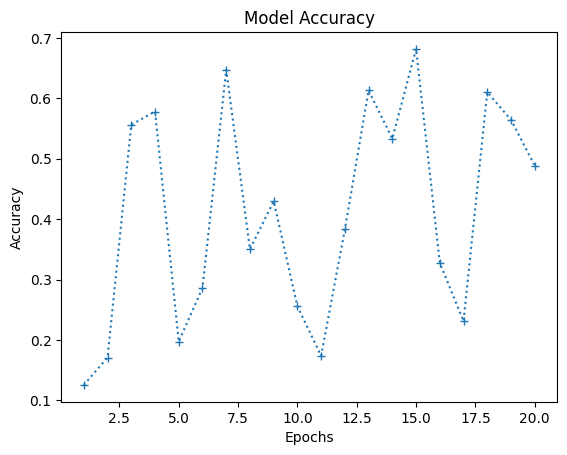

In [10]:
plot_data(accuracy, type="Accuracy", title="Model Accuracy")